**MY FATHERS BUSSINESS ANALYSIS & FORECASTING(retail liquor bussiness)**

* This project is based on a real business scenario inspired by my father’s retail liquor business, Teja Wines, operating multiple branches in Prakasam district, Andhra Pradesh.
The goal of this project is to analyze sales patterns, customer behavior, and future trends to support data-driven business decisions.

* 📁 Dataset Description
* 🔹 Data Source
* Manually simulated based on real shop sales registers
Designed to mimic raw business data (missing values, duplicates, outliers)
 * 🔹 Dataset Size
 * 40,000 records
 * 5 shops
 * 5 major brands
 * Approximately 40 transactions per day
* Covers last 6 months of 2025
* 🔹 Shop Branches Included
* Teja Wines – Ongole
* Teja Wines – Yedugullapadu
* Teja Wines – Kothapatnam
* Teja Wines – Sitharampuram Koshtalu
* Teja Wines – SN Padu

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
df = pd.read_csv('/content/Teja_Wines_40000_Messy_Raw_Data.csv')

In [18]:
df.shape

(40500, 9)

In [7]:
df.head()

,Shop_Name,Location,Date,Product_Type,Brand,Quantity_Sold,Unit_Price,Payment_Mode,Customer_Age
0,Teja Wines – Yedugullapadu,Yedugullapadu,2025-12-28,Vodka,NaN,2.0,150,UPI,23.0
1,Teja Wines – Kothapatnam,Kothapatnam,2025-07-14,Vodka,NaN,3.0,220,Cash,62.0
2,Teja Wines – Ongole,Ongole,2025-11-16,Wine,Signature,10.0,120,NaN,60.0
3,Teja Wines – Sitharampuram Koshtalu,Sitharampuram Koshtalu,2025-07-02,Brandy,Smirnoff,20.0,150,UPI,32.0
4,Teja Wines – SN Padu,SN Padu,2025-07-17,Beer,Kingfisher,20.0,1000,Cash,27.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40500 entries, 0 to 40499
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Shop_Name      40500 non-null  object 
 1   Location       40500 non-null  object 
 2   Date           40500 non-null  object 
 3   Product_Type   40500 non-null  object 
 4   Brand          34770 non-null  object 
 5   Quantity_Sold  35323 non-null  float64
 6   Unit_Price     40500 non-null  int64  
 7   Payment_Mode   30324 non-null  object 
 8   Customer_Age   39639 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 2.8+ MB


In [9]:
df.describe()

,Quantity_Sold,Unit_Price,Customer_Age
count,35323.000000,40500.000000,39639.000000
mean,6.653059,384.767901,41.096799
std,7.756251,685.247139,13.621073
min,1.000000,90.000000,18.000000
25%,2.000000,150.000000,29.000000
50%,4.000000,220.000000,41.000000
75%,10.000000,500.000000,53.000000
max,120.000000,20000.000000,90.000000


In [12]:
df['Product_Type'].value_counts()

,count
Product_Type,
Brandy,6854
Wine,6842
Vodka,6784
Beer,6759
Whisky,6662
Rum,6599


In [13]:
df['Location'].value_counts()

,count
Location,
Kothapatnam,8183
SN Padu,8144
Ongole,8095
Yedugullapadu,8039
Sitharampuram Koshtalu,8039


In [14]:
df['Brand'].value_counts()

,count
Brand,
Bacardi,5901
McDowell's,5887
Royal Stag,5844
Kingfisher,5736
Signature,5713
Smirnoff,5689


In [15]:
df['Brand'].isnull().sum()

np.int64(5730)

**Exploratory Data Analysis**

Dealing with missing values in brand column


In [19]:
df['Brand'].isna().sum()


np.int64(5730)

In [20]:
#most sold brand count
most_sold_brand = (
    df.dropna(subset=['Brand'])
      .groupby(['Product_Type', 'Brand'])
      .size()
      .reset_index(name='count')
      .sort_values(['Product_Type', 'count'], ascending=[True, False])
      .drop_duplicates('Product_Type')
)

most_sold_brand


,Product_Type,Brand,count
0,Beer,Bacardi,1036
8,Brandy,McDowell's,1026
15,Rum,Royal Stag,987
22,Vodka,Signature,995
26,Whisky,McDowell's,1008
31,Wine,Kingfisher,1022


In [21]:
#mapping the brand name with product_type
brand_map = dict(
    zip(most_sold_brand['Product_Type'], most_sold_brand['Brand'])
)

brand_map


{'Beer': 'Bacardi',
 'Brandy': "McDowell's",
 'Rum': 'Royal Stag',
 'Vodka': 'Signature',
 'Whisky': "McDowell's",
 'Wine': 'Kingfisher'}

In [22]:
#replacing missing values
df['Brand'] = df['Brand'].fillna(
    df['Product_Type'].map(brand_map)
)


In [23]:
df['Brand'].isna().sum()

np.int64(0)

Dealing missing values in quantity_sold column

In [24]:
#brand popularity
brand_qty_trend = (
    df.dropna(subset=['Quantity_Sold'])
      .groupby('Brand')['Quantity_Sold']
      .mean()
      .to_dict()
)

brand_qty_trend


{'Bacardi': 6.689885019163473,
 'Kingfisher': 6.77179269328802,
 "McDowell's": 6.562573964497042,
 'Royal Stag': 6.661045818429569,
 'Signature': 6.641126954131592,
 'Smirnoff': 6.595787362086258}

In [25]:
#price based quantity
def base_quantity_by_price(unit_price):
    if unit_price <= 150:
        return 4
    elif unit_price <= 300:
        return 3
    elif unit_price <= 750:
        return 2
    else:
        return 1


In [26]:
# price + brand trend
def infer_quantity(unit_price, brand):
    base_qty = base_quantity_by_price(unit_price)

    brand_factor = brand_qty_trend.get(brand, 3)
    adjusted_qty = base_qty + (brand_factor - 3)
    final_qty = int(round(adjusted_qty + np.random.uniform(-0.5, 0.5)))

    return max(1, final_qty)


In [27]:
# fill only missing values
df['Quantity_Sold'] = df.apply(
    lambda row: infer_quantity(row['Unit_Price'], row['Brand'])
    if pd.isna(row['Quantity_Sold']) else row['Quantity_Sold'],
    axis=1
)


In [28]:
df['Quantity_Sold'].isna().sum()


np.int64(0)

Dealing Missing values in payement_mode column

In [29]:
df['Payment_Mode'].isna().sum()


np.int64(10176)

In [30]:
payment_modes = ['Cash', 'UPI', 'Card']


In [32]:
#priority based distribution
df.loc[df['Payment_Mode'].isna(), 'Payment_Mode'] = np.random.choice(
    payment_modes,
    size=df['Payment_Mode'].isna().sum(),
    p=[0.5, 0.35, 0.15]  # Cash, UPI, Card
)



In [34]:
df['Payment_Mode'].value_counts(normalize=True)


,proportion
Payment_Mode,
UPI,0.334173
Card,0.333012
Cash,0.332815


In [35]:
df['Payment_Mode'].isna().sum()

np.int64(0)

In [36]:
df.head()

,Shop_Name,Location,Date,Product_Type,Brand,Quantity_Sold,Unit_Price,Payment_Mode,Customer_Age
0,Teja Wines – Yedugullapadu,Yedugullapadu,2025-12-28,Vodka,Signature,2.0,150,UPI,23.0
1,Teja Wines – Kothapatnam,Kothapatnam,2025-07-14,Vodka,Signature,3.0,220,Cash,62.0
2,Teja Wines – Ongole,Ongole,2025-11-16,Wine,Signature,10.0,120,Cash,60.0
3,Teja Wines – Sitharampuram Koshtalu,Sitharampuram Koshtalu,2025-07-02,Brandy,Smirnoff,20.0,150,UPI,32.0
4,Teja Wines – SN Padu,SN Padu,2025-07-17,Beer,Kingfisher,20.0,1000,Cash,27.0


Dealing missing values in Coustmer_age column

In [37]:
df['Customer_Age'].isna().sum()


np.int64(861)

In [39]:
# median in age group
brand_age_median = df.groupby('Brand')['Customer_Age'].median()


In [40]:
import numpy as np

def fill_customer_age(row):
    if pd.isna(row['Customer_Age']):
        median_age = brand_age_median.get(row['Brand'], np.nan)
        if pd.isna(median_age):
            return np.random.randint(25, 45)
        age = int(np.random.normal(loc=median_age, scale=3))

        return min(max(age, 21), 60)

    return row['Customer_Age']


In [41]:
df['Customer_Age'] = df.apply(fill_customer_age, axis=1)


In [42]:
df['Customer_Age'].isna().sum()


np.int64(0)

Checking Outliers in quantity_sold, unit_price, column


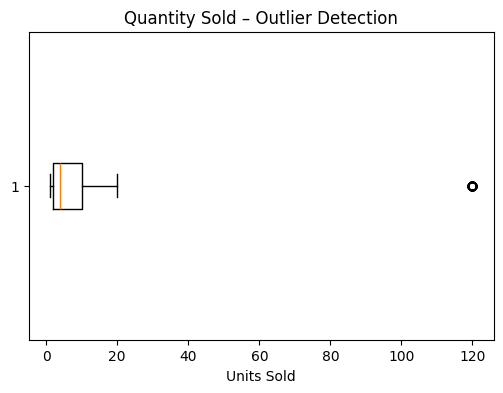

In [44]:
#outliers in quantity_sold
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.boxplot(df['Quantity_Sold'].dropna(), vert=False)
plt.title("Quantity Sold – Outlier Detection")
plt.xlabel("Units Sold")
plt.show()



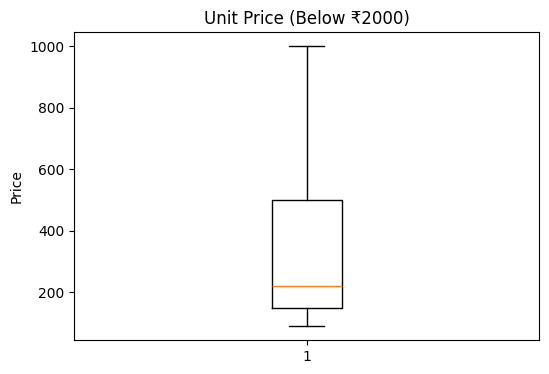

In [46]:
#outliers in unit price
filtered_price = df[df['Unit_Price'] < 2000]['Unit_Price']

plt.figure(figsize=(6,4))
plt.boxplot(filtered_price)
plt.title("Unit Price (Below ₹2000)")
plt.ylabel("Price")
plt.show()


2.0
10.0


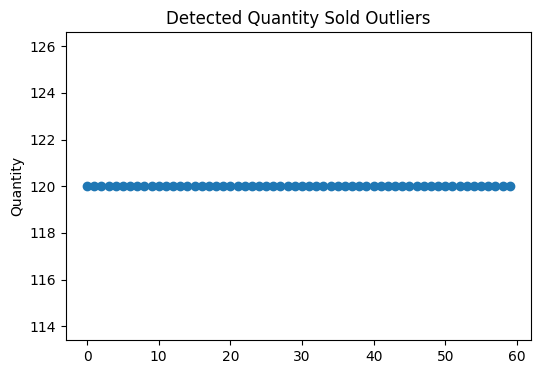

In [49]:
#USING IQR RULE
Q1 = df['Quantity_Sold'].quantile(0.25)
Q3 = df['Quantity_Sold'].quantile(0.75)
IQR = Q3 - Q1
print(Q1)
print(Q3)

outliers = df[(df['Quantity_Sold'] < Q1 - 1.5*IQR) |
              (df['Quantity_Sold'] > Q3 + 1.5*IQR)]

plt.figure(figsize=(6,4))
plt.scatter(range(len(outliers)), outliers['Quantity_Sold'])
plt.title("Detected Quantity Sold Outliers")
plt.ylabel("Quantity")
plt.show()



In [50]:
Q1 = df['Unit_Price'].quantile(0.25)
Q3 = df['Unit_Price'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

Q1, Q3, IQR, lower_bound, upper_bound


(np.float64(150.0),
 np.float64(500.0),
 np.float64(350.0),
 np.float64(-375.0),
 np.float64(1025.0))

In [51]:
unit_price_outliers = df[
    (df['Unit_Price'] < lower_bound) |
    (df['Unit_Price'] > upper_bound)
]

unit_price_outliers.shape


(40, 9)

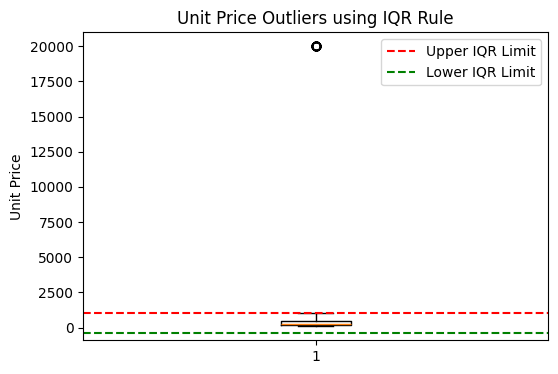

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.boxplot(df['Unit_Price'].dropna())
plt.axhline(upper_bound, color='red', linestyle='--', label='Upper IQR Limit')
plt.axhline(lower_bound, color='green', linestyle='--', label='Lower IQR Limit')
plt.title("Unit Price Outliers using IQR Rule")
plt.ylabel("Unit Price")
plt.legend()
plt.show()


In [55]:
#capping extreme values in unit_price
df['Unit_Price'] = df['Unit_Price'].clip(lower=lower_bound, upper=upper_bound)


In [61]:
# type conversion of quantity_sold and coustmer_age column
df['Quantity_Sold'] = (
    pd.to_numeric(df['Quantity_Sold'], errors='coerce')
    .astype('Int64')
)

df['Customer_Age'] = (
    pd.to_numeric(df['Customer_Age'], errors='coerce')
    .astype('Int64')
)

In [62]:
df.head()

,Shop_Name,Location,Date,Product_Type,Brand,Quantity_Sold,Unit_Price,Payment_Mode,Customer_Age
0,Teja Wines – Yedugullapadu,Yedugullapadu,2025-12-28,Vodka,Signature,2,150,UPI,23
1,Teja Wines – Kothapatnam,Kothapatnam,2025-07-14,Vodka,Signature,3,220,Cash,62
2,Teja Wines – Ongole,Ongole,2025-11-16,Wine,Signature,10,120,Cash,60
3,Teja Wines – Sitharampuram Koshtalu,Sitharampuram Koshtalu,2025-07-02,Brandy,Smirnoff,20,150,UPI,32
4,Teja Wines – SN Padu,SN Padu,2025-07-17,Beer,Kingfisher,20,1000,Cash,27


In [63]:
# new column creation total_sales
df['total_sales'] = df['Quantity_Sold'] * df['Unit_Price']

In [64]:
df.head()

,Shop_Name,Location,Date,Product_Type,Brand,Quantity_Sold,Unit_Price,Payment_Mode,Customer_Age,total_sales
0,Teja Wines – Yedugullapadu,Yedugullapadu,2025-12-28,Vodka,Signature,2,150,UPI,23,300
1,Teja Wines – Kothapatnam,Kothapatnam,2025-07-14,Vodka,Signature,3,220,Cash,62,660
2,Teja Wines – Ongole,Ongole,2025-11-16,Wine,Signature,10,120,Cash,60,1200
3,Teja Wines – Sitharampuram Koshtalu,Sitharampuram Koshtalu,2025-07-02,Brandy,Smirnoff,20,150,UPI,32,3000
4,Teja Wines – SN Padu,SN Padu,2025-07-17,Beer,Kingfisher,20,1000,Cash,27,20000


Data Analysis
* shop wise analysis
* brand wise analysis
* time based analysis

In [65]:
# shop analysis complete data overview
shop_analysis = (
    df.groupby('Shop_Name')
      .agg(
          total_revenue=('total_sales', 'sum'),
          total_quantity=('Quantity_Sold', 'sum'),
          avg_bill_value=('total_sales', 'mean'),
          total_transactions=('total_sales', 'count')
      )
      .reset_index()
      .sort_values(by='total_revenue', ascending=False)
)

shop_analysis


,Shop_Name,total_revenue,total_quantity,avg_bill_value,total_transactions
0,Teja Wines – Kothapatnam,20418030,55290,2495.176586,8183
1,Teja Wines – Ongole,19583695,53577,2419.233477,8095
2,Teja Wines – SN Padu,19231205,54191,2361.395506,8144
4,Teja Wines – Yedugullapadu,18969520,53091,2359.686528,8039
3,Teja Wines – Sitharampuram Koshtalu,18962860,52792,2358.858067,8039


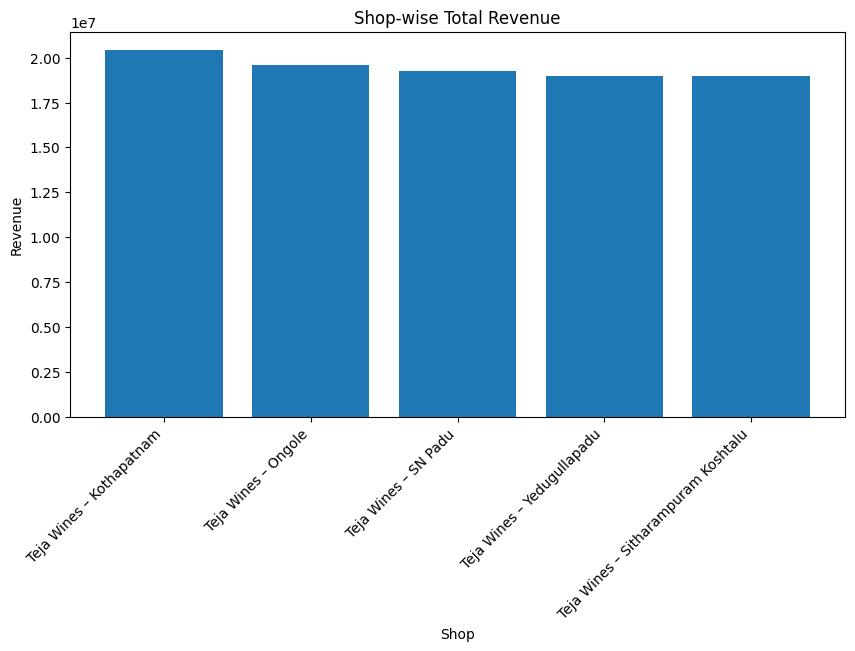

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(shop_analysis['Shop_Name'], shop_analysis['total_revenue'])
plt.xticks(rotation=45, ha='right')
plt.title("Shop-wise Total Revenue")
plt.ylabel("Revenue")
plt.xlabel("Shop")
plt.show()


* kothapatnam shop has highest revenue among all shops due to urban population

In [67]:
#brand wise analysis
brand_analysis = (
    df.groupby('Brand')
      .agg(
          total_revenue=('total_sales', 'sum'),
          total_quantity=('Quantity_Sold', 'sum'),
          avg_unit_price=('Unit_Price', 'mean')
      )
      .reset_index()
      .sort_values(by='total_revenue', ascending=False)
)

brand_analysis


,Brand,total_revenue,total_quantity,avg_unit_price
2,McDowell's,18000495,51006,359.474023
1,Kingfisher,16662870,45433,369.480809
0,Bacardi,16655785,45860,366.143543
3,Royal Stag,16480735,45024,370.663371
4,Signature,15867505,44171,370.386173
5,Smirnoff,13497920,37447,360.131833


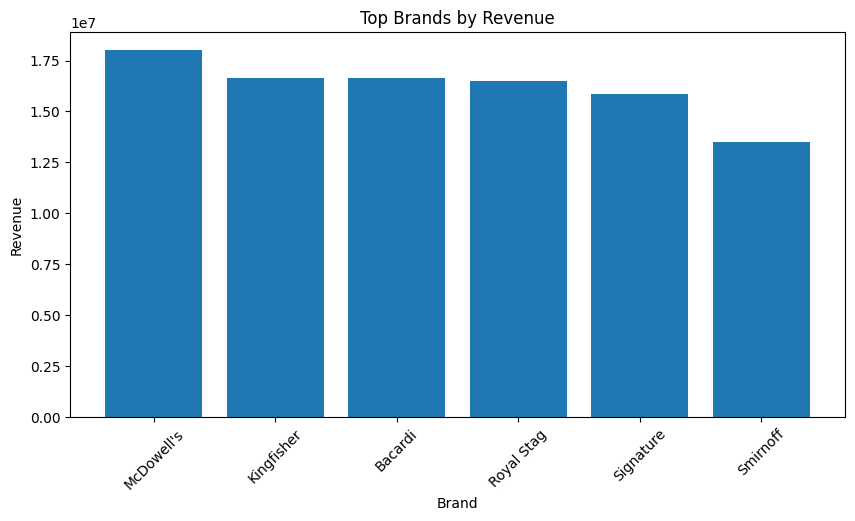

In [69]:
# top brands by revenue
top_brands = brand_analysis.head(10)

plt.figure(figsize=(10,5))
plt.bar(top_brands['Brand'], top_brands['total_revenue'])
plt.xticks(rotation=45)
plt.title("Top Brands by Revenue")
plt.ylabel("Revenue")
plt.xlabel("Brand")
plt.show()


* McDowell's sale in higher among all brands

In [70]:
# time based analysis
df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Date'].dt.day_name()
df['Month'] = df['Date'].dt.month


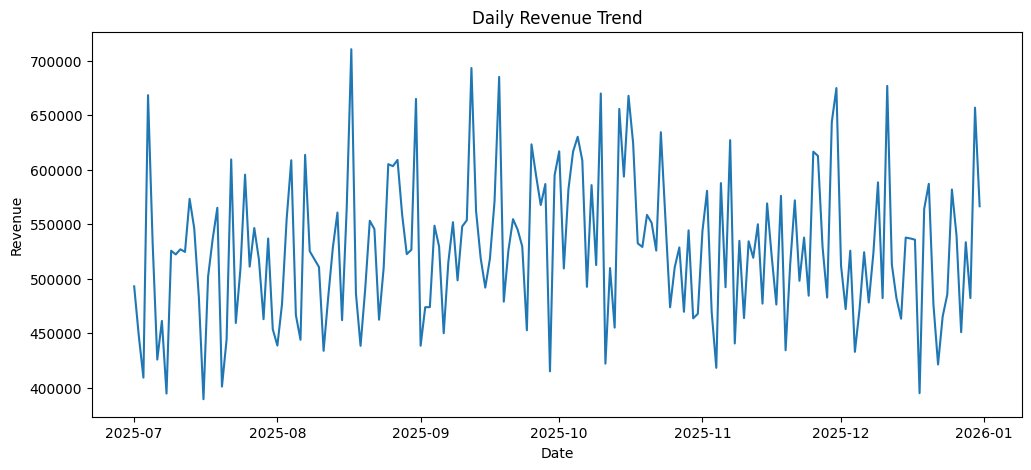

In [71]:
daily_sales = df.groupby('Date')['total_sales'].sum()

plt.figure(figsize=(12,5))
plt.plot(daily_sales.index, daily_sales.values)
plt.title("Daily Revenue Trend")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()


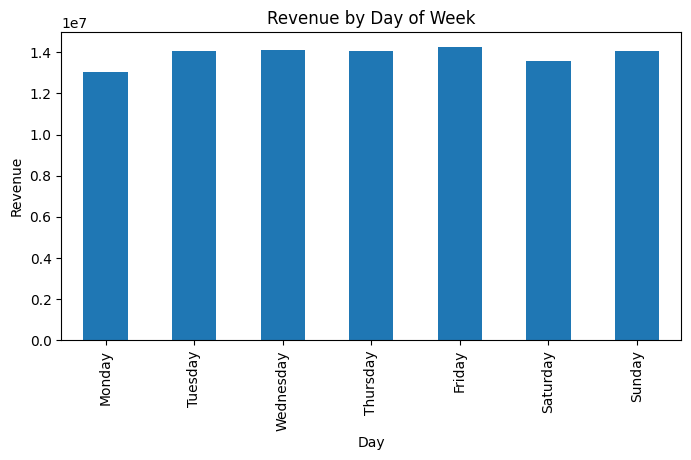

In [72]:
# weekday and weekend analysis
weekday_sales = (
    df.groupby('Day')['total_sales']
      .sum()
      .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
)

weekday_sales.plot(kind='bar', figsize=(8,4), title='Revenue by Day of Week')
plt.ylabel("Revenue")
plt.show()


In [73]:
df['Date'] = pd.to_datetime(df['Date'])


In [74]:
df['Day_Type'] = df['Date'].dt.weekday.apply(
    lambda x: 'Weekend' if x >= 5 else 'Weekday'
)


In [75]:
daily_sales = (
    df.groupby(['Date', 'Day_Type'])['total_sales']
      .sum()
      .reset_index()
)


In [76]:
avg_sales_daytype = (
    daily_sales.groupby('Day_Type')['total_sales']
    .mean()
    .reset_index(name='avg_daily_sales')
)

avg_sales_daytype


,Day_Type,avg_daily_sales
0,Weekday,526870.871212
1,Weekend,531122.211538


* weekend has more avg_daily_sale than weekends due to more leisure time and bulk purchase

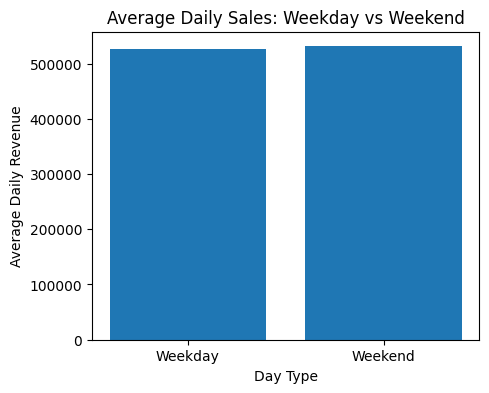

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
plt.bar(
    avg_sales_daytype['Day_Type'],
    avg_sales_daytype['avg_daily_sales']
)
plt.title("Average Daily Sales: Weekday vs Weekend")
plt.ylabel("Average Daily Revenue")
plt.xlabel("Day Type")
plt.show()


In [78]:
# each shop weekday and weekend analysis
shop_daily_sales = (
    df.groupby(['Shop_Name', 'Date', 'Day_Type'])['total_sales']
      .sum()
      .reset_index()
)


In [79]:
shop_daytype_avg = (
    shop_daily_sales
    .groupby(['Shop_Name', 'Day_Type'])['total_sales']
    .mean()
    .reset_index(name='avg_daily_sales')
)

shop_daytype_avg


,Shop_Name,Day_Type,avg_daily_sales
0,Teja Wines – Kothapatnam,Weekday,109900.984848
1,Teja Wines – Kothapatnam,Weekend,113675.0
2,Teja Wines – Ongole,Weekday,109287.537879
3,Teja Wines – Ongole,Weekend,99187.307692
4,Teja Wines – SN Padu,Weekday,103492.651515
5,Teja Wines – SN Padu,Weekend,107118.75
6,Teja Wines – Sitharampuram Koshtalu,Weekday,102668.106061
7,Teja Wines – Sitharampuram Koshtalu,Weekend,104051.346154
8,Teja Wines – Yedugullapadu,Weekday,101521.590909
9,Teja Wines – Yedugullapadu,Weekend,107089.807692


* As compare to weekdays shops has more avg_daily_sale in weekends

In [81]:
# month wise revenue analysis
df['Month_Name'] = df['Date'].dt.month_name()
daily_sales = (
    df.groupby(['Date', 'Month', 'Month_Name'])['total_sales']
      .sum()
      .reset_index()
)

In [82]:
monthly_metrics = (
    daily_sales
    .groupby(['Month', 'Month_Name'])
    .agg(
        total_revenue=('total_sales', 'sum'),
        avg_daily_revenue=('total_sales', 'mean'),
        active_days=('Date', 'nunique')
    )
    .reset_index()
    .sort_values('Month')
)

monthly_metrics


,Month,Month_Name,total_revenue,avg_daily_revenue,active_days
0,7,July,15571610,502310.0,31
1,8,August,16472905,531384.032258,31
2,9,September,16088315,536277.166667,30
3,10,October,17094795,551445.0,31
4,11,November,15977535,532584.5,30
5,12,December,15960150,514843.548387,31


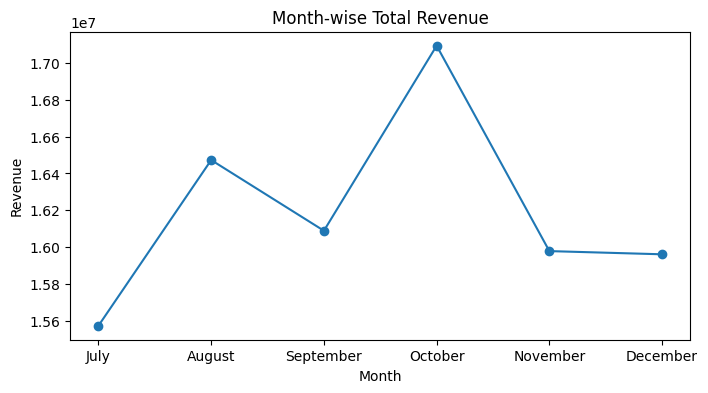

In [83]:
plt.figure(figsize=(8,4))
plt.plot(
    monthly_metrics['Month_Name'],
    monthly_metrics['total_revenue'],
    marker='o'
)
plt.title("Month-wise Total Revenue")
plt.ylabel("Revenue")
plt.xlabel("Month")
plt.show()


* october has highest sale revenue do to dhasara effect(sessonality trend)

DATA VIAUALIZATION

In [84]:
# age group bins formation
age_bins = [18, 25, 35, 45, 55, 65]
age_labels = ['18–24', '25–34', '35–44', '45–54', '55–64']

df['Age_Group'] = pd.cut(
    df['Customer_Age'],
    bins=age_bins,
    labels=age_labels,
    right=False
)


In [89]:
# age group X brand
age_brand = (
    df.groupby(['Age_Group', 'Brand'], observed=True)['Quantity_Sold']
      .sum()
      .reset_index()
)


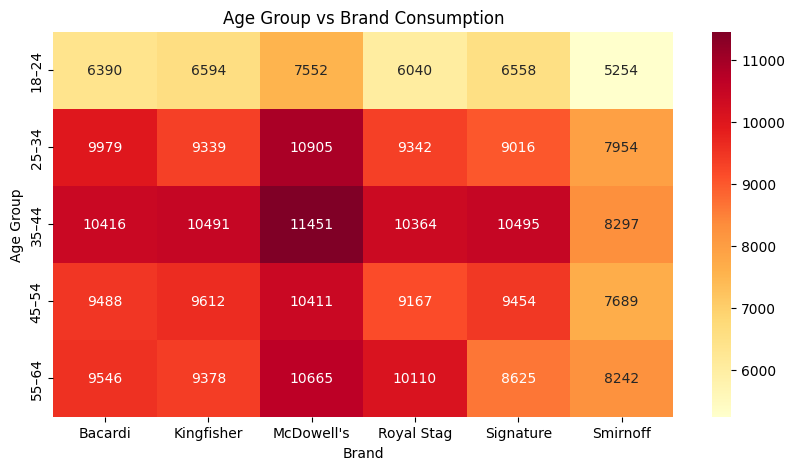

In [93]:
pivot_age_brand = age_brand.pivot(
    index='Age_Group',
    columns='Brand',
    values='Quantity_Sold'
).fillna(0).astype(float)

plt.figure(figsize=(10,5))
sns.heatmap(pivot_age_brand, cmap='YlOrRd', annot=True, fmt='.0f')
plt.title("Age Group vs Brand Consumption")
plt.ylabel("Age Group")
plt.xlabel("Brand")
plt.show()

* 18–24 → Beer / Kingfisher
* 25–34 → Whisky / Signature
* 35–44 → Royal Stag, McDowell’s

In [96]:
# shop X age_group
shop_age = (
    df.groupby(['Shop_Name', 'Age_Group'], observed= True)['Quantity_Sold']
      .sum()
      .reset_index()
)


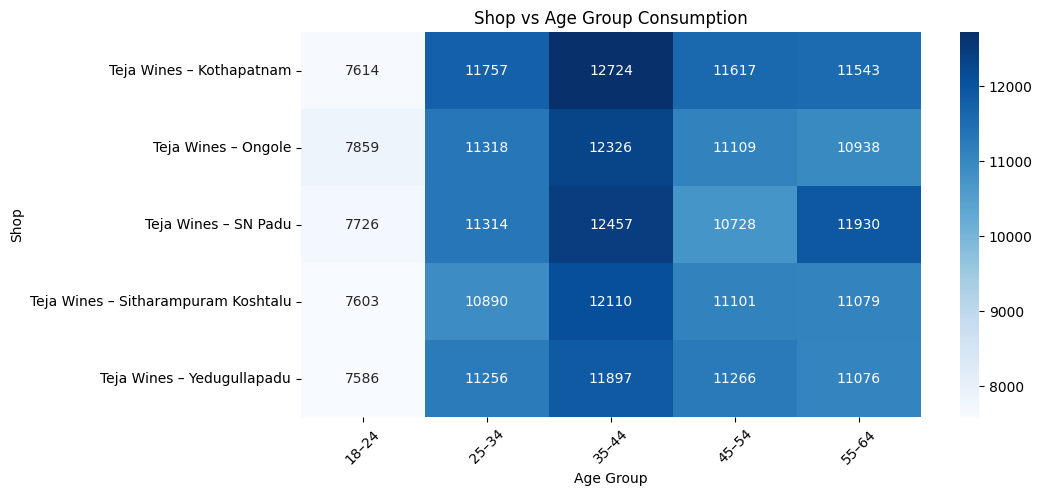

In [98]:
pivot_shop_age = shop_age.pivot(
    index='Shop_Name',
    columns='Age_Group',
    values='Quantity_Sold'
).fillna(0).astype(float)

plt.figure(figsize=(10,5))
sns.heatmap(pivot_shop_age, cmap='Blues', annot=True, fmt='.0f')
plt.title("Shop vs Age Group Consumption")
plt.ylabel("Shop")
plt.xlabel("Age Group")
plt.xticks(rotation=45)
plt.show()


* Ongole → young adults (college crowd)
* SN Padu → middle-aged regulars
* Kothapatnam → mixed profile

In [99]:
# shop X brand
shop_brand = (
    df.groupby(['Shop_Name', 'Brand'], observed=True)['total_sales']
      .sum()
      .reset_index()
)


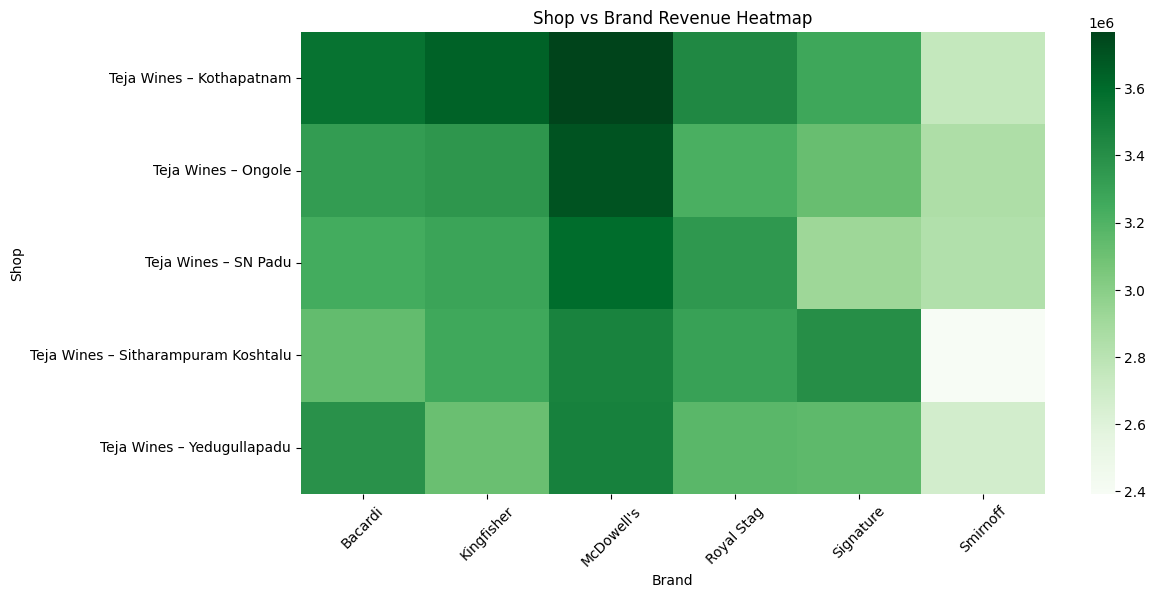

In [100]:
pivot_shop_brand = shop_brand.pivot(
    index='Shop_Name',
    columns='Brand',
    values='total_sales'
).fillna(0).astype(float)

plt.figure(figsize=(12,6))
sns.heatmap(pivot_shop_brand, cmap='Greens', annot=False)
plt.title("Shop vs Brand Revenue Heatmap")
plt.ylabel("Shop")
plt.xlabel("Brand")
plt.xticks(rotation=45)
plt.show()


* onole and kothapatnam has more mcdowels sales
* snpadu has more vodka sales

Model A: Shop-wise Sales Forecast (Time Series)

In [118]:
# next six months forecast for all shops
shop_daily = (
    df.groupby(['Date', 'Shop_Name'])['total_sales']
      .sum()
      .reset_index()
)


In [102]:
!pip install prophet


In [114]:
from prophet import Prophet
import pandas as pd

forecast_list = []

for shop in shop_daily['Shop_Name'].unique():

    shop_df = shop_daily[shop_daily['Shop_Name'] == shop]

    prophet_df = shop_df.rename(columns={
        'Date': 'ds',
        'total_sales': 'y'
    })

    model = Prophet(
        weekly_seasonality=True,
        yearly_seasonality=True,
        daily_seasonality=False
    )

    model.fit(prophet_df)

    future = model.make_future_dataframe(periods=180)
    forecast = model.predict(future)

    forecast['Shop_Name'] = shop
    forecast_list.append(forecast[['ds', 'yhat', 'Shop_Name']])



In [115]:
combined_forecast = pd.concat(forecast_list)


In [116]:
last_date = df['Date'].max()

future_forecast = combined_forecast[
    combined_forecast['ds'] > last_date
]


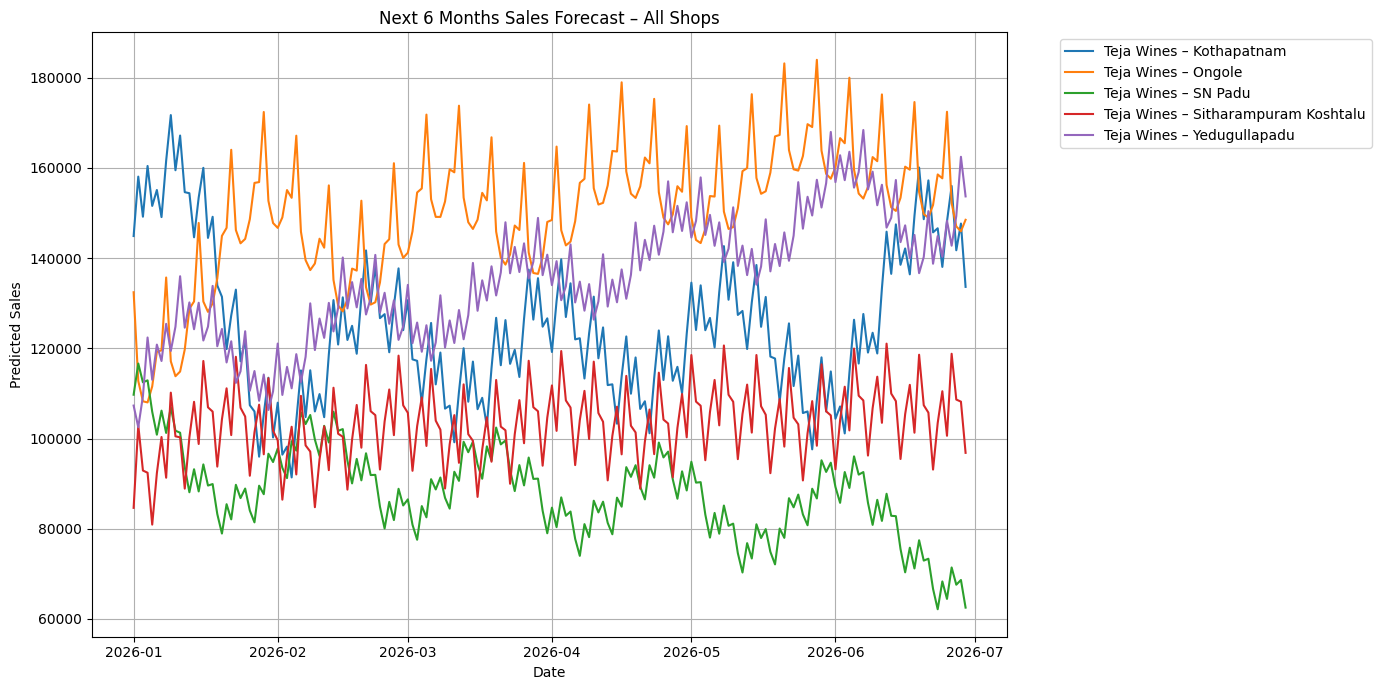

In [117]:
plt.figure(figsize=(14, 7))

for shop in future_forecast['Shop_Name'].unique():
    shop_data = future_forecast[future_forecast['Shop_Name'] == shop]
    plt.plot(shop_data['ds'], shop_data['yhat'], label=shop)

plt.title("Next 6 Months Sales Forecast – All Shops")
plt.xlabel("Date")
plt.ylabel("Predicted Sales")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



MODEL B — BRAND CONSUMPTION FORECAST

In [110]:
df['Month'] = df['Date'].dt.to_period('M')

brand_monthly = (
    df.groupby(['Month', 'Brand'])['Quantity_Sold']
      .sum()
      .reset_index()
)


In [111]:
brand_trend = (
    brand_monthly
    .sort_values(['Brand', 'Month'])
    .groupby('Brand')
    .tail(3)   # last 3 months
)


In [112]:
brand_growth = (
    brand_monthly
    .pivot(index='Month', columns='Brand', values='Quantity_Sold')
    .pct_change()
    .mean()
    .sort_values(ascending=False)
)

brand_growth


,0
Brand,
Kingfisher,0.019553
Royal Stag,0.014121
Signature,0.009752
McDowell's,0.004565
Smirnoff,0.003688
Bacardi,-0.00229


* Positive growth → high demand brands
* Negative growth → declining brands

In [113]:
# next 6 months growth rate prediction
top_future_brands = brand_growth.head(5)
top_future_brands


,0
Brand,
Kingfisher,0.019553
Royal Stag,0.014121
Signature,0.009752
McDowell's,0.004565
Smirnoff,0.003688
